## Example file

This notebook show how to work with the MRIA model with a fictive industry x industry input-output table.

Let's first load the required python modules, outside the modules within this package:

In [1]:
import os
import pandas as pd 
import geopandas as gp
import numpy as np
import matplotlib.

And now the mria_py modules:

In [2]:
from create_table import Table
from base_model import MRIA

The 'create_table' module will load the input-output table from an external source and prepares it for use within the MRIA model. The 'base_model' module is the MRIA model itself.

The next step is to specify the filepath of the input-output table:

In [3]:
filepath = '..\input_data\The_Vale.xlsx'

In some cases, you only want to use a subset of the table. As such, we need to specify a list of countries to be used in the model:

In [4]:
list_countries = ['Elms','Hazel','Montagu','Fogwell','Riverside','Oatlands']

We can now create a new data object and run the 'prepare data' script: 

In [7]:
DATA = Table('TheVale',filepath,2010,list_countries)
DATA.prep_data()

And now we can create the a model instance:

In [8]:
MRIA_model = MRIA('TheVale',list_countries,DATA.sectors)
MRIA_model.create_sets(FD_SET=['FinDem'])
MRIA_model.create_alias()

The next step is to transform the data from the table into a set of parameters and variables to be used in the MRIA model:

In [9]:
MRIA_model.baseline_data(DATA)    

And before we want to run it, we want to create a dataframe to save the outcomes of the model:

In [11]:
output = pd.DataFrame()
output['x_in'] = pd.Series(MRIA_model.X.get_values())

Let's run the baseline model!

In [12]:
MRIA_model.run_basemodel()

Ipopt 3.11.1: warm_start_init_point=yes
warm_start_bound_push=1e-06
warm_start_mult_bound_push=1e-06
mu_init=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      551
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       24
                     variab

The model spits out the log file of the solver. As shown in the log file, the model has reached an optimal solution! Let's see if the solver also reproduced the baseline situation:

In [13]:
output['x_out'] = pd.Series(MRIA_model.X.get_values())
output['diff'] = output['x_out'] - output['x_in']

print(sum(output['diff']))

-0.0452070138836


And in a quick visualisation:

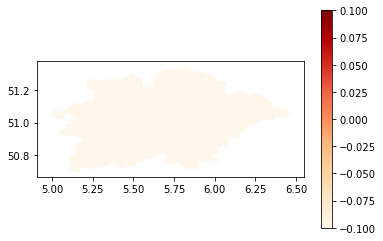

In [17]:
%matplotlib inline

shape_TheVale = gp.read_file('..\\input_data\\The_Vale.shp')
reg_loss = pd.DataFrame(output[['diff','x_in']].groupby(level=0).sum())
reg_loss['Region'] = reg_loss.index

reg_loss['diff'] = reg_loss['diff'].round()

reg_shap = pd.merge(shape_TheVale, reg_loss, on='Region', how='inner')
reg_shap.plot(column='diff', cmap='OrRd', legend=True) 